## State space models - Chandrasekhar recursions

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader

Although most operations related to state space models rely on the Kalman filtering recursions, in some special cases one can use a separate method often called "Chandrasekhar recursions". These provide an alternative way to iteratively compute the conditional moments of the state vector, and in some cases they can be substantially less computationally intensive than the Kalman filter recursions. For complete details, see the paper "Using the 'Chandrasekhar Recursions' for Likelihood Evaluation of DSGE Models" (Herbst, 2015). Here we just sketch the basic idea.

#### State space models and the Kalman filter

Recall that a time-invariant state space model can be written:

$$
\begin{aligned}
y_t &= Z \alpha_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, H) \\
\alpha_{t+1} & = T \alpha_t + R \eta_t, \qquad \eta_t \sim N(0, Q) \\
\alpha_1 & \sim N(a_1, P_1)
\end{aligned}
$$

where $y_t$ is a $p \times 1$ vector and $\alpha_t$ is an $m \times 1$ vector.

Each iteration of the Kalman filter, say at time $t$, can be split into three parts:

1. **Initialization**: specification of $a_t$ and $P_t$ that define the conditional state distribution, $\alpha_t \mid y^{t-1} \sim N(a_t, P_t)$.
2. **Updating**: computation of $a_{t|t}$ and $P_{t|t}$ that define the conditional state distribution, $\alpha_t \mid y^{t} \sim N(a_{t|t}, P_{t|t})$.
3. **Prediction**: computation of $a_{t+1}$ and $P_{t+1}$ that define the conditional state distribution, $\alpha_{t+1} \mid y^{t} \sim N(a_{t+1}, P_{t+1})$.

Of course after the first iteration, the prediction part supplies the values required for initialization of the next step.

Focusing on the prediction step, the Kalman filter recursions yield:

$$
\begin{aligned}
a_{t+1} & = T a_{t|t} \\
P_{t+1} & = T P_{t|t} T' + R Q R' \\
\end{aligned}
$$

where the matrices $T$ and $P_{t|t}$ are each $m \times m$, where $m$ is the size of the state vector $\alpha$. In some cases, the state vector can become extremely large, which can imply that the matrix multiplications required to produce $P_{t+1}$ can be become computationally intensive.

#### Example: seasonal autoregression

As an example, notice that an AR(r) model (we use $r$ here since we already used $p$ as the dimension of the observation vector) can be put into state space form as:

$$
\begin{aligned}
y_t &= \alpha_t \\
\alpha_{t+1} & = T \alpha_t + R \eta_t, \qquad \eta_t \sim N(0, Q)
\end{aligned}
$$

where:


$$
\begin{aligned}
T = \begin{bmatrix}
\phi_1 & \phi_2 & \dots & \phi_r \\
1 & 0 & & 0 \\
\vdots & \ddots & & \vdots \\
0 &  & 1 & 0 \\
\end{bmatrix} \qquad
R = \begin{bmatrix}
1 \\
0 \\
\vdots \\
0
\end{bmatrix} \qquad
Q = \begin{bmatrix}
\sigma^2
\end{bmatrix}
\end{aligned}
$$

In an AR model with daily data that exhibits annual seasonality, we might want to fit a model that incorporates lags up to $r=365$, in which case the state vector would be at least $m = 365$. The matrices $T$ and $P_{t|t}$ then each have $365^2 = 133225$ elements, and so most of the time spent computing the likelihood function (via the Kalman filter) can become dominated by the matrix multiplications in the prediction step.

#### State space models and the Chandrasekhar recursions

The Chandrasekhar recursions replace equation $P_{t+1} = T P_{t|t} T' + R Q R'$ with a different recursion:

$$
P_{t+1} = P_t + W_t M_t W_t'
$$

but where $W_t$ is a matrix with dimension $m \times p$ and $M_t$ is a matrix with dimension $p \times p$, where $p$ is the dimension of the observed vector $y_t$. These matrices themselves have recursive formulations. For more general details and for the formulas for computing $W_t$ and $M_t$, see Herbst (2015).

**Important note**: unlike the Kalman filter, the Chandrasekhar recursions can not be used for every state space model. In particular, the latter has the following restrictions (that are not required for the use of the former):

- The model must be time-invariant, except that time-varying intercepts are permitted.
- Stationary initialization of the state vector must be used (this rules out all models in non-stationary components)
- Missing data is not permitted

To understand why this formula can imply more efficient computations, consider again the SARIMAX case, above. In this case, $p = 1$, so that $M_t$ is a scalar and we can rewrite the Chandrasekhar recursion as:

$$
P_{t+1} = P_t + M_t \times W_t W_t'
$$

The matrices being multiplied, $W_t$, are then of dimension $m \times 1$, and in the case $r=365$, they each only have $365$ elements, rather than $365^2$ elements. This implies substantially fewer computations are required to complete the prediction step.

#### Convergence

A factor that complicates a straightforward discussion of performance implications is the well-known fact that in time-invariant models, the predicted state covariance matrix will converge to a constant matrix. This implies that there exists an $S$ such that, for every $t > S$, $P_t = P_{t+1}$. Once convergence has been achieved, we can eliminate the equation for $P_{t+1}$ from the prediction step altogether.

In simple time series models, like AR(r) models, convergence is achieved fairly quickly, and this can limit the performance benefit to using the Chandrasekhar recursions. Herbst (2015) focuses instead on DSGE (Dynamic Stochastic General Equilibrium) models instead, which often have a large state vector and often a large number of periods to achieve convergence. In these cases, the performance gains can be quite substantial.

#### Practical example

As a practical example, we will consider monthly data that has a clear seasonal component. In this case, we look at the inflation rate of apparel, as measured by the consumer price index. A graph of the data indicates strong seasonality.

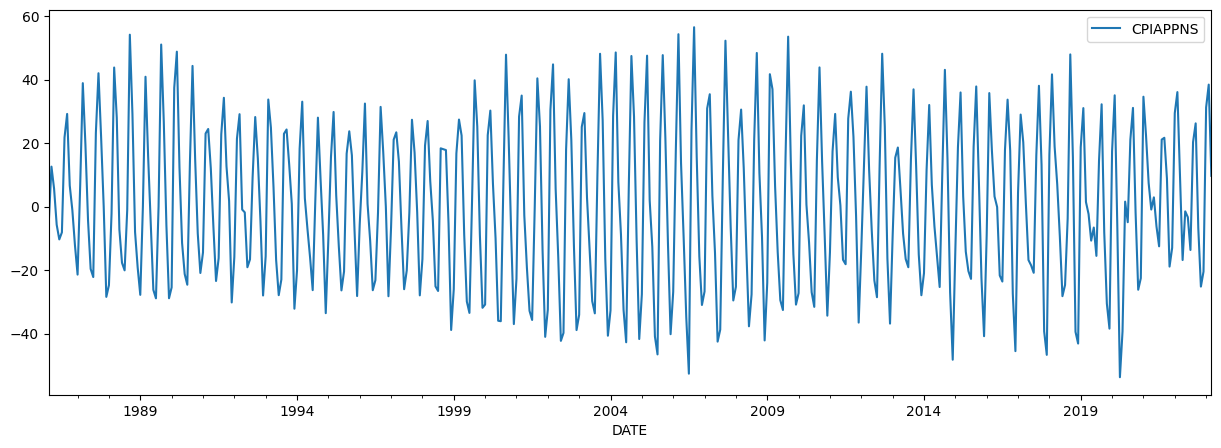

In [2]:
cpi_apparel = DataReader('CPIAPPNS', 'fred', start='1986')
cpi_apparel.index = pd.DatetimeIndex(cpi_apparel.index, freq='MS')
inf_apparel = np.log(cpi_apparel).diff().iloc[1:] * 1200
inf_apparel.plot(figsize=(15, 5));

We will construct two model instances. The first will be set to use the Kalman filter recursions, while the second will be set to use the Chandrasekhar recursions. This setting is controlled by the `ssm.filter_chandrasekhar` property, as shown below.

The model we have in mind is a seasonal autoregression, where we include the first 6 months as lags as well as the given month in each of the previous 15 years as lags. This implies that the state vector has dimension $m = 186$, which is large enough that we might expect to see some substantial performance gains by using the Chandrasekhar recursions.

**Remark**: We set `tolerance=0` in each model - this has the effect of preventing the filter from ever recognizing that the prediction covariance matrix has converged. *This is not recommended in practice*. We do this here to highlight the superior performance of the Chandrasekhar recursions when they are used in every period instead of the typical Kalman filter recursions. Later, we will show the performance in a more realistic setting that we do allow for convergence.

In [3]:
# Model that will apply Kalman filter recursions
mod_kf = sm.tsa.SARIMAX(inf_apparel, order=(6, 0, 0), seasonal_order=(15, 0, 0, 12), tolerance=0)
print(mod_kf.k_states)

# Model that will apply Chandrasekhar recursions
mod_ch = sm.tsa.SARIMAX(inf_apparel, order=(6, 0, 0), seasonal_order=(15, 0, 0, 12), tolerance=0)
mod_ch.ssm.filter_chandrasekhar = True

186


We time computation of the log-likelihood function, using the following code:

```python
%timeit mod_kf.loglike(mod_kf.start_params)
%timeit mod_ch.loglike(mod_ch.start_params)
```

This results in:

```
171 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
85 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
```

The implication is that in this experiment, the Chandrasekhar recursions improved performance by about a factor of 2.

As we mentioned above, in the previous experiment we disabled convergence of the predicted covariance matrices, so the results there are an upper bound. Now we allow for convergence, as usual, by removing the `tolerance=0` argument:

In [4]:
# Model that will apply Kalman filter recursions
mod_kf = sm.tsa.SARIMAX(inf_apparel, order=(6, 0, 0), seasonal_order=(15, 0, 0, 12))
print(mod_kf.k_states)

# Model that will apply Chandrasekhar recursions
mod_ch = sm.tsa.SARIMAX(inf_apparel, order=(6, 0, 0), seasonal_order=(15, 0, 0, 12))
mod_ch.ssm.filter_chandrasekhar = True

186


Again, we time computation of the log-likelihood function, using the following code:

```python
%timeit mod_kf.loglike(mod_kf.start_params)
%timeit mod_ch.loglike(mod_ch.start_params)
```

This results in:

```
114 ms ± 7.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.5 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
```

The Chandrasekhar recursions still improve performance, but now only by about 33%. The reason for this is that after convergence, we no longer need to compute the predicted covariance matrices, so that for those post-convergence periods, there will be no difference in computation time between the two approaches. Below we check the period in which convergence was achieved:

In [5]:
res_kf = mod_kf.filter(mod_kf.start_params)
print('Convergence at t=%d, of T=%d total observations' %
      (res_kf.filter_results.period_converged, res_kf.nobs))

Convergence at t=186, of T=446 total observations


Since convergence happened relatively early, we are already avoiding the expensive matrix multiplications in more than half of the periods.

However, as mentioned above, larger DSGE models may not achieve convergence for most or all of the periods in the sample, and so we could perhaps expect to achieve performance gains more similar to the first example. In their 2019 paper "Euro area real-time density forecasting with financial or labor market frictions", McAdam and Warne note that in their applications, "Compared with the standard Kalman filter, it is our experience that these recursions speed up
the calculation of the log-likelihood for the three models by roughly 50 percent". This is about the same result as we found in our first example.

#### Aside on multithreaded matrix algebra routines

The timings above are based on the Numpy installation installed via Anaconda, which uses Intel's MKL BLAS and LAPACK libraries. These implement multithreaded processing to speed up matrix algebra, which can be particularly helpful for operations on the larger matrices we're working with here. To get a sense of how this affects results, we could turn off multithreading by putting the following in the first cell of this notebook.

```python
import os
os.environ["MKL_NUM_THREADS"] = "1"
```

When we do this, the timings of the first example change to:

```
307 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
97.5 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
```

and the timings of the second example change to:

```
178 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
78.9 ms ± 950 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
```

Both are slower, but the typical Kalman filter is affected much more.

This is not unexpected; the performance differential between single and multithreaded linear algebra is much greater in the typical Kalman filter case, because the whole point of the Chandrasekhar recursions is to reduce the size of the matrix operations. It means that if multithreaded linear algebra is unavailable, the Chandrasekhar recursions offer even greater performance gains.

#### Chandrasekhar recursions and the univariate filtering approach

It is also possible to combine the Chandrasekhar recursions with the univariate filtering approach of Koopman and Durbin (2000), by making use of the results of Aknouche and Hamdi in their 2007 paper "Periodic Chandrasekhar recursions". An initial implementation of this combination is included in Statsmodels. However, experiments suggest that this tends to degrade performance compared to even the usual Kalman filter. This accords with the computational savings reported for the univariate filtering method, which suggest that savings are highest when the state vector is small relative to the observation vector.

#### Bibliography

Aknouche, Abdelhakim, and Fayçal Hamdi. "Periodic Chandrasekhar recursions." arXiv preprint arXiv:0711.3857 (2007).

Herbst, Edward. "Using the “Chandrasekhar Recursions” for likelihood evaluation of DSGE models." Computational Economics 45, no. 4 (2015): 693-705.

Koopman, Siem J., and James Durbin. "Fast filtering and smoothing for multivariate state space models." Journal of Time Series Analysis 21, no. 3 (2000): 281-296.

McAdam, Peter, and Anders Warne. "Euro area real-time density forecasting with financial or labor market frictions." International Journal of Forecasting 35, no. 2 (2019): 580-600.